In [228]:
import numpy as np
import matplotlib.pyplot as plt

## Test sensitivity is secondary to frequency and turnaround time for COVID-19 surveillance
Larremore et al.  
https://larremorelab.github.io/covid19testgroup

In [234]:
N = 100
incubation_time = (2.5,3.5)
peak_time = (1,1.8)
peak_load = (10**7,10**11)
drop_times = (5,10)

In [235]:
inc_times = np.random.uniform(*incubation_time,N)
peak_times = inc_times + np.random.uniform(*peak_time, N)
peak_loads = np.random.uniform(*peak_load, N)
t_drop = peak_times + np.random.uniform(*drop_times, N)

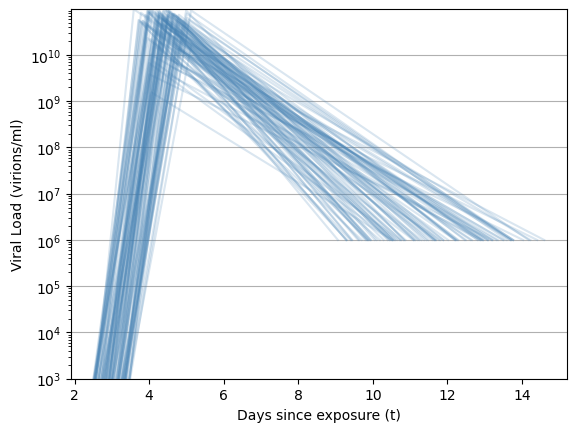

In [236]:
fig, ax = plt.subplots()
ax.grid(axis ='y')
ax.set_ylim([10**3,peak_loads.max()])
ax.set_ylabel("Viral Load (virions/ml)")
ax.set_xlabel("Days since exposure (t)")
for i in range(N): # For every infected person
    x = [inc_times[i],peak_times[i],t_drop[i]]
    y = [10**3, peak_loads[i],10**6]
    ax.semilogy(x,y,c='steelblue',alpha=0.2)

# OR just don't even bother with the log scale

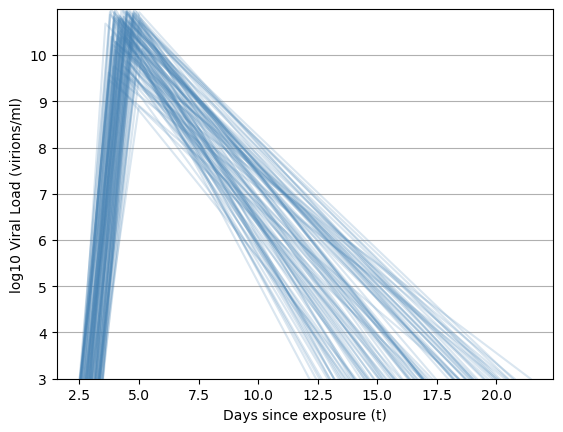

In [245]:
peak_loads = np.random.uniform(*peak_load, N)
peak_loads = np.log10(peak_loads)

fig, ax = plt.subplots()
ax.grid(axis ='y')
ax.set_ylim([3,peak_loads.max()])
ax.set_ylabel("log10 Viral Load (virions/ml)")
ax.set_xlabel("Days since exposure (t)")

for i in range(N): # For every infected person
    x = [inc_times[i],peak_times[i],t_drop[i]]
    y = [3, peak_loads[i],6,3]
    dx = t_drop[i] - peak_times[i]
    dy = 6- peak_loads[i]
    x2 = (3-peak_loads[i])*(dx/dy) + peak_times[i]
    x.append(x2)
    ax.plot(x,y,c='steelblue',alpha=0.2)

# Differential Equation Epidemic Modeling
https://pdfs.semanticscholar.org/d05e/b4bb6a7ac91e0fb18c3f14cf49b899b9447b.pdf?_ga=2.155510258.850999848.1598848957-1117122962.1598848957

In [58]:
from scipy.integrate import odeint

# SI ODE Model
- S : Susceptible
- I : Infected

#### Two Equilibria
- $(S^{\star},I^{\star}) = (N,0)$ : **Disease-free Equilibrium** - No infected
- $(S^{\star\star},I^{\star\star}) = (0,N)$ : **Endemic Equilibrium** - All infected
  
$(S,I) \notin \{(S^{\star},I^{\star}), (S^{\star\star},I^{\star\star})\}$
- Always converges to endemic equilibrium

In [114]:
BETA = 5E-5
N = 10_000
days = np.arange(0,50)
def dIdt(y,t):
    return BETA*(N-y)*y

In [115]:
I = odeint(dIdt,y0=1,t=days)*100/N

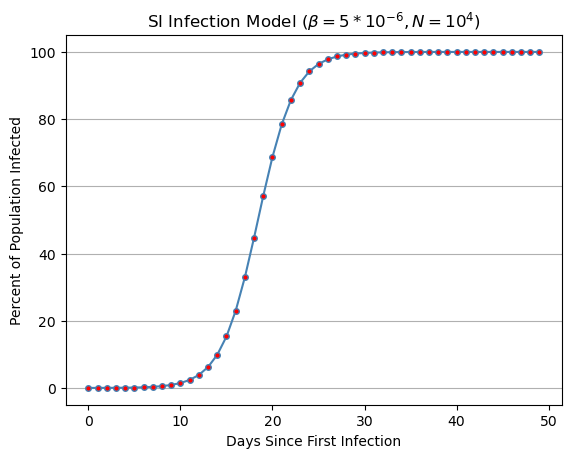

In [116]:
plt.plot(days, y, c='steelblue', marker='o', ms = 4, mfc = 'red')
plt.xlabel("Days Since First Infection")
plt.ylabel("Percent of Population Infected")
plt.title(r"SI Infection Model ($\beta=5*10^{-6}, N=10^{4}$)")
plt.grid(axis='y')
plt.show()

# SIR ODE Model
- S : Susceptible
- I : Infected
- R : Recovered
- $\beta$ : Rate of infection proportionality constant
- $\alpha$ : Rate of recovery proportionality constant
$$\frac{dS}{dt} = -\beta I S$$  
$$\frac{dI}{dt} = \beta I S - \alpha I$$  
$$\frac{dR}{dt} = \alpha I$$

In [247]:
N = 100_000
alpha = 5E-2
beta = 1E-5
params = (N,alpha,beta)

y0 = [1,0]
times = np.linspace(0,50,1000)

def SIR(y, t, params):
    I,R = y
    N, alpha, beta = params
    S = N - I - R
    I_dot = beta*I*(S) - alpha*I
    R_dot = alpha*I
    return [I_dot, R_dot]

y = odeint(SIR,y0,times, args = (params,))
Inf = y[:,0]
Rec = y[:,1]
Sus = N - (Inf + Rec)

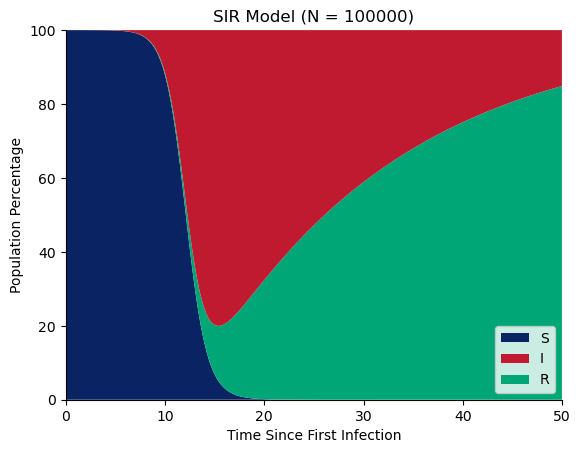

In [248]:
fig, ax = plt.subplots()
ax.stackplot(times,np.c_[Sus,Rec,Inf].T*100/N,labels = 'S R I'.split(), colors = ['0A2463','00A676','BF1A2F'])
handles, labels = ax.get_legend_handles_labels()
ax.legend([handles[0],handles[2], handles[1]], 'S I R'.split(), loc = 'lower right')
ax.set_xlabel("Time Since First Infection")
ax.set_ylabel("Population Percentage")
ax.set_xlim([0,times.max()])
ax.set_ylim([0,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('SIR Model (N = {})'.format(N))
plt.show()

# SEIR ODE Model
- S : Susceptible
- E : Exposed -> Infected, but not infectious
- I : Infected
- R : Recovered
- $\beta$ : Rate of infection proportionality constant
- $\alpha$ : Rate of recovery proportionality constant
- $\gamma$ : Rate of infectiousness proportionality constant
$$\frac{dS}{dt} = -\beta I S$$  
$$\frac{dE}{dt} = \beta I S - \gamma E$$  
$$\frac{dI}{dt} = \gamma E - \alpha I$$  
$$\frac{dR}{dt} = \alpha I$$

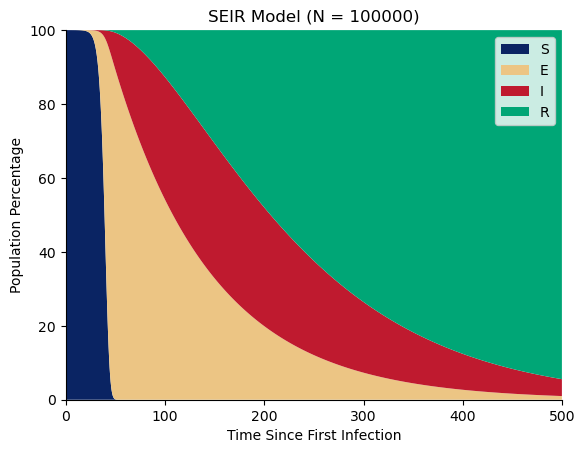

In [263]:
N = 100_000
alpha = 1E-2
beta = 10E-5
gamma = 1E-2
params = (N,alpha,beta,gamma)

y0 = [1,0,0] # E I R
times = np.linspace(0,500,1000)

def SEIR(y, t, params):
    E,I,R = y
    N, alpha, beta, gamma = params
    S = N - (E + I + R)
    E_dot = beta*I*S - gamma*E
    I_dot = gamma*E - alpha*I
    R_dot = alpha*I
    return [E_dot, I_dot, R_dot]

y = odeint(SEIR,y0,times, args = (params,))

Exp = y[:,0]
Inf = y[:,1]
Rec = y[:,2]
Sus = N - (Exp + Inf + Rec)

fig, ax = plt.subplots()
palette1 = ['0A2463','ECC584','BF1A2F','00A676']
palette2 = '093397 F4CB58 EC1532 00B884'.split()
ax.stackplot(times,
             np.c_[Sus,Exp,Inf,Rec].T*100/N,
             labels = 'S E I R'.split(), 
             colors = palette1)

# handles, labels = ax.get_legend_handles_labels()
# ax.legend([handles[0],handles[1],handles[3], handles[2]], 'S E I R'.split(), loc = 'lower right')
ax.legend()
ax.set_xlabel("Time Since First Infection")
ax.set_ylabel("Population Percentage")
ax.set_xlim([0,times.max()])
ax.set_ylim([0,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('SEIR Model (N = {})'.format(N))
plt.show()

# SIS ODE Model
- S : Susceptible
- I : Infected
- S : Susceptible (Again - No antibody immunity)
- $\beta$ : Rate of infection proportionality constant
- $\alpha$ : Rate of recovery proportionality constant

$$\frac{dS}{dt} = -\beta I S + \alpha I$$  
$$\frac{dI}{dt} = \beta I S - \alpha I$$  
$$S \leftarrow N-I$$
$$\therefore \frac{dI}{dt} \leftarrow \beta I \left(N-I\right) - \alpha I = \beta I \left( N - \frac{\alpha}{\beta} - I\right)$$

### Manipulating Equilibrium Points
$\Gamma$ - Infection Equilibrium Ratio
$$\frac{\alpha}{\beta} \leftarrow N\left(1-\Gamma \right)$$

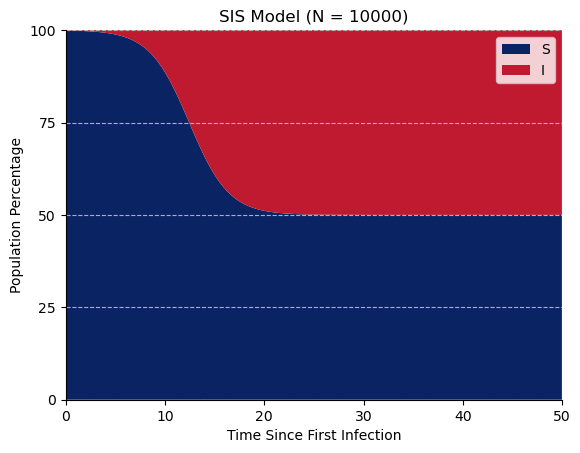

In [331]:
N = 10_000
beta = 1E-4
alpha = 0.5*N*beta#1E-1
y0 = 10
params = (alpha, beta, N)
times = np.linspace(0,50,1000)

def SIS(y, t, params):
    I = y
    alpha, beta, N = params
    return beta*I*(N - (alpha/beta) - I)

Inf = odeint(SIS, y0=y0, t=times, args=(params,))*100/N
Sus = 100 - Inf

fig, ax = plt.subplots()
ax.stackplot(times,np.c_[Sus,Inf].T,labels = ['S', 'I'], colors = ['0A2463','BF1A2F'])
ax.legend()
ax.set_xlabel("Time Since First Infection")
ax.set_ylabel("Population Percentage")
ax.set_yticks([0,25,50,75,100])
ax.grid(axis='y', linestyle = '--')
ax.set_xlim([0,times.max()])
ax.set_ylim([0,100])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('SIS Model (N = {})'.format(N))
plt.show()